# 凝聚階層集群(Agglomerative Hierarchical Clustering, AHC)

## 載入相關套件

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 生成資料

In [2]:
np.random.seed(123)
variables = ["X", "Y", "Z"]
labels = ["ID_0", "ID_1", "ID_2", "ID_3", "ID_4"]

X = np.random.random_sample([5, 3]) * 10
df = pd.DataFrame(X, columns=variables, index=labels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


## 計算集群彼此間的距離

In [3]:
from scipy.spatial.distance import pdist, squareform

row_dist = pd.DataFrame(
    squareform(pdist(df, metric="euclidean")), columns=labels, index=labels
)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


## 計算平均連結距離

In [4]:
from scipy.cluster.hierarchy import linkage

row_clusters = linkage(pdist(df, metric="euclidean"), method="average")
pd.DataFrame(
    row_clusters,
    columns=["row label 1", "row label 2", "distance", "no. of items in clust."],
    index=["cluster %d" % (i + 1) for i in range(row_clusters.shape[0])],
)


,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.141375,3.0
cluster 4,6.0,7.0,6.308931,5.0


## 繪製樹狀圖(dendrogram)

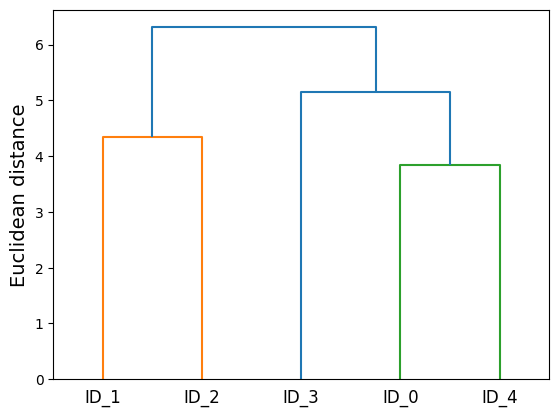

In [5]:
from scipy.cluster.hierarchy import dendrogram

row_dendr = dendrogram(row_clusters, labels=labels)
plt.ylabel("Euclidean distance", fontsize=14);

## 繪製熱力圖

/tmp/ipykernel_54054/4043465990.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axm.set_xticklabels([""] + list(df_rowclust.columns))
/tmp/ipykernel_54054/4043465990.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axm.set_yticklabels([""] + list(df_rowclust.index));


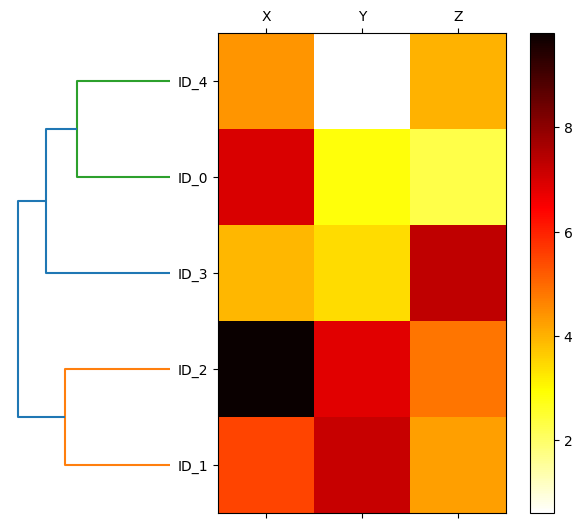

In [6]:
fig = plt.figure(figsize=(8, 8), facecolor="white")
axd = fig.add_axes([0.09, 0.1, 0.2, 0.6])  # x-pos, y-pos, width, height

# 樹狀圖顯示在左邊
row_dendr = dendrogram(row_clusters, orientation="left")

# 降冪排序
df_rowclust = df.iloc[row_dendr["leaves"][::-1]]

# 不顯示刻度
axd.set_xticks([])
axd.set_yticks([])

# 不顯示座標軸
for i in axd.spines.values():
    i.set_visible(False)

# 繪製熱力圖
axm = fig.add_axes([0.23, 0.1, 0.6, 0.6])  # x-pos, y-pos, width, height
cax = axm.matshow(df_rowclust, interpolation="nearest", cmap="hot_r")
fig.colorbar(cax)
axm.set_xticklabels([""] + list(df_rowclust.columns))
axm.set_yticklabels([""] + list(df_rowclust.index));

## Scikit-learn AgglomerativeClustering

In [7]:
from sklearn.cluster import AgglomerativeClustering

# 分 3 類
ac = AgglomerativeClustering(n_clusters=3, metric="euclidean", linkage="complete")
labels = ac.fit_predict(X)
print("Cluster labels: %s" % labels)

Cluster labels: [1 0 0 2 1]


In [8]:
# 分 2 類
ac = AgglomerativeClustering(n_clusters=2, metric="euclidean", linkage="complete")
labels = ac.fit_predict(X)
print("Cluster labels: %s" % labels)

Cluster labels: [0 1 1 0 0]


## 使用鳶尾花資料集測試

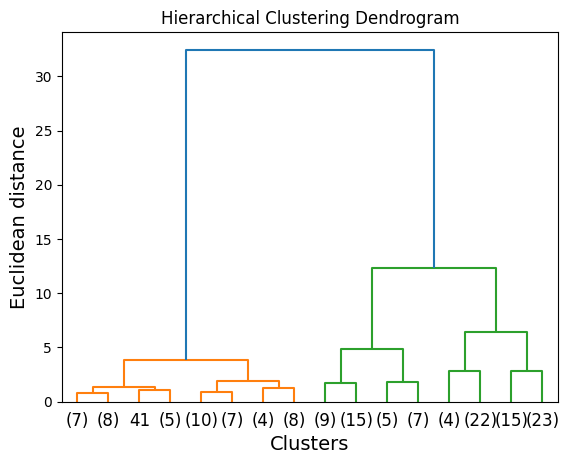

In [9]:
from sklearn.datasets import load_iris


# 繪製樹狀圖
def plot_dendrogram(model, **kwargs):
    # 計算每個集群的筆數
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # 繪製樹狀圖
    dendrogram(linkage_matrix, **kwargs)


# 載入資料集
X, _ = load_iris(return_X_y=True)

# distance_threshold=0 表示會建立完整的樹狀圖(dendrogram)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="level", p=3)  # 限制 3 層
plt.ylabel("Euclidean distance", fontsize=14)
plt.xlabel("Clusters", fontsize=14);

## 各種距離衡量方式的比較

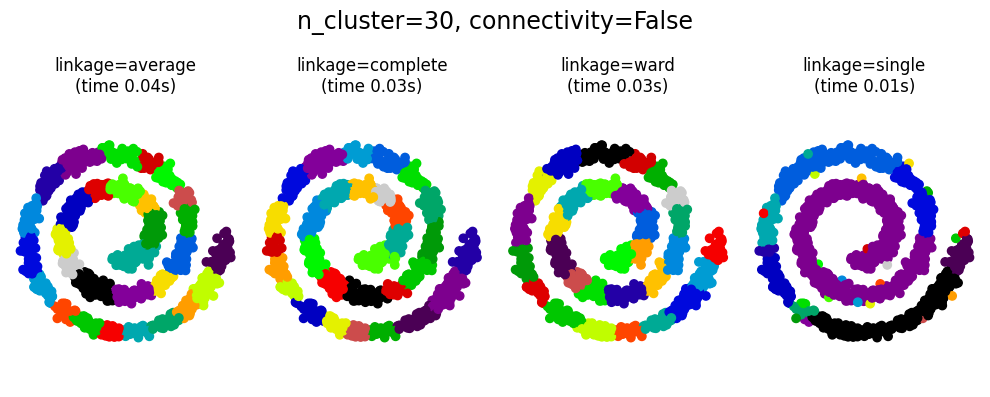

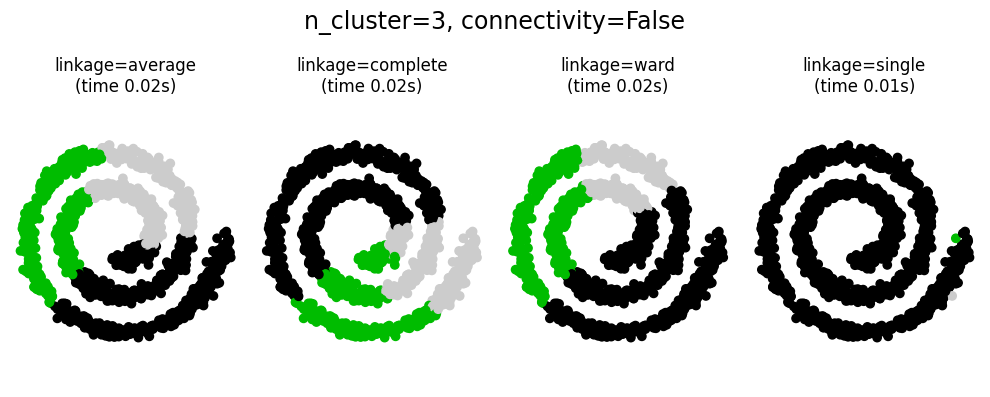

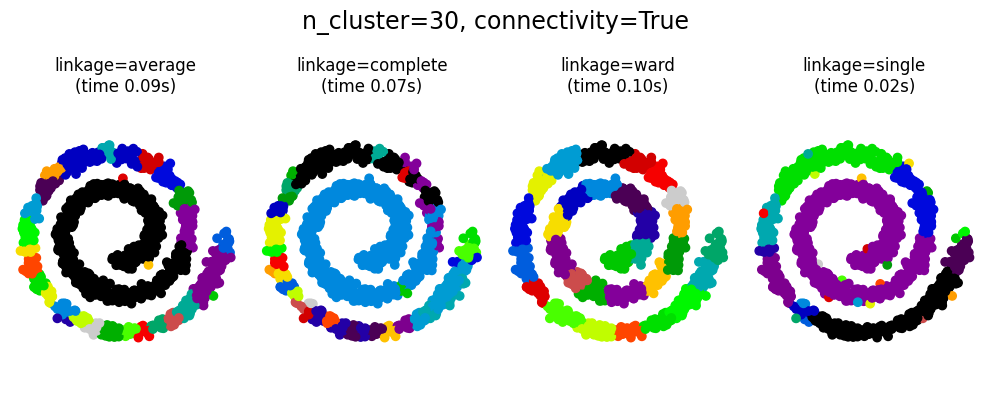

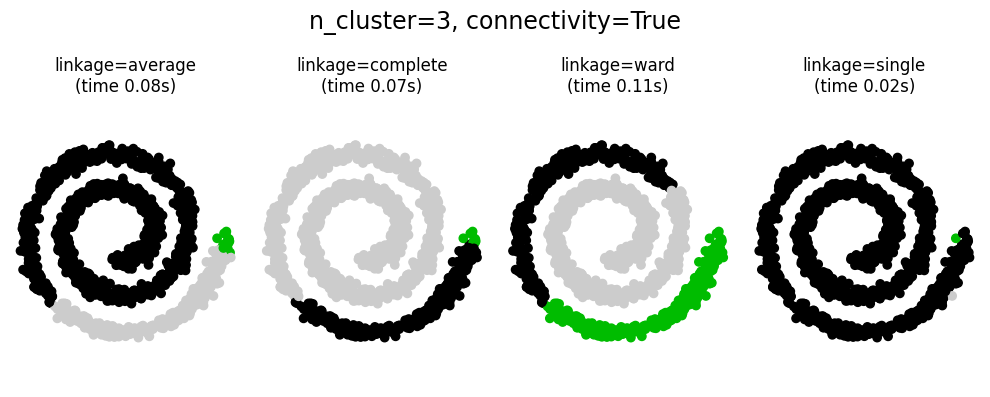

In [10]:
import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

# Generate sample data
n_samples = 1500
np.random.seed(0)
t = 1.5 * np.pi * (1 + 3 * np.random.rand(1, n_samples))
x = t * np.cos(t)
y = t * np.sin(t)


X = np.concatenate((x, y))
X += 0.7 * np.random.randn(2, n_samples)
X = X.T

# Create a graph capturing local connectivity. Larger number of neighbors
# will give more homogeneous clusters to the cost of computation
# time. A very large number of neighbors gives more evenly distributed
# cluster sizes, but may not impose the local manifold structure of
# the data
knn_graph = kneighbors_graph(X, 30, include_self=False)

for connectivity in (None, knn_graph):
    for n_clusters in (30, 3):
        plt.figure(figsize=(10, 4))
        for index, linkage in enumerate(("average", "complete", "ward", "single")):
            plt.subplot(1, 4, index + 1)
            model = AgglomerativeClustering(
                linkage=linkage, connectivity=connectivity, n_clusters=n_clusters
            )
            t0 = time.time()
            model.fit(X)
            elapsed_time = time.time() - t0
            plt.scatter(X[:, 0], X[:, 1], c=model.labels_, cmap=plt.cm.nipy_spectral)
            plt.title(
                "linkage=%s\n(time %.2fs)" % (linkage, elapsed_time),
                fontdict=dict(verticalalignment="top"),
            )
            plt.axis("equal")
            plt.axis("off")

            plt.subplots_adjust(bottom=0, top=0.89, wspace=0, left=0, right=1)
            plt.suptitle(
                "n_cluster=%i, connectivity=%r"
                % (n_clusters, connectivity is not None),
                size=17,
            )
            plt.tight_layout()